In [19]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, expon

warnings.filterwarnings("ignore")

In [2]:
data_dir = os.path.dirname(os.path.dirname(os.getcwd()))
data_dir = os.path.join(data_dir, "dataset")
data_transformed = pd.read_excel(f"{data_dir}/data_transformed.xlsx", sheet_name="Sheet1")

In [3]:
columns = ["NMHC(GT)", "NOx(GT)", "CO(GT)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "NO2(GT)", "PT08.S4(NO2)", "PT08.S5(O3)"]

data_transformed = data_transformed[columns]
data_transformed.head()

,NMHC(GT),NOx(GT),CO(GT),PT08.S2(NMHC),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
0,20.673444,137.174844,0.473975,0.441183,0.811790,0.432234,0.643497,0.640258
1,20.558514,134.894175,0.466248,0.176077,1.176723,0.266791,0.358282,-0.005912
2,20.478471,135.959147,0.468824,0.130797,1.071902,0.440112,0.349185,0.216773
3,20.450300,137.371967,0.468824,0.157089,0.922823,0.503139,0.411793,0.499643
4,20.340964,135.959147,0.461097,-0.172285,1.273779,0.455869,0.211127,0.295561


In [21]:
# Gamma Regression: Metropolis-Hastings
def gamma_posterior(alpha, beta, y):
    likelihood = np.sum(gamma.logpdf(y, a=alpha, scale=1/beta))
    #prior_alpha = -0.5 * (alpha - 2)**2  # Weak prior around 2
    #prior_beta = -0.5 * (beta - 2)**2   # Weak prior around 2
    prior_alpha = -0.5 * ((alpha - 2)**2 / 0.5**2)  # Narrower prior
    prior_beta = -0.5 * ((beta - 1)**2 / 0.5**2)
    return likelihood + prior_alpha + prior_beta

def metropolis_gamma(y, feature_name="NMHC(GT)", iterations=1000, step_alpha=0.002, step_beta=0.002):
    alpha, beta = 2.0, 2.0
    samples = []
    trace_alpha, trace_beta = [], []  # Initialize traces for alpha and beta
    acceptance_count = 0  # Initialize acceptance counter

    for t in range(iterations):
        alpha_new = abs(alpha + np.random.normal(0, step_alpha))
        if feature_name=="NOx(GT)":
            beta_new = abs(beta + gamma.rvs(a=2.0, scale=step_beta))
        else:
            beta_new = abs(beta + np.random.normal(0, step_beta))

        posterior_current = gamma_posterior(alpha, beta, y)
        posterior_new = gamma_posterior(alpha_new, beta_new, y)

        acceptance_ratio = np.exp(posterior_new - posterior_current)

        if np.random.rand() < acceptance_ratio:
            alpha, beta = alpha_new, beta_new
            acceptance_count += 1

        samples.append((alpha, beta))
        trace_alpha.append(alpha)
        trace_beta.append(beta)

        # Print acceptance rate every 100 iterations
        if (t + 1) % 100 == 0:
            print(f"Iteration {t + 1}: Acceptance Rate = {acceptance_count / (t + 1):.2f}")

    # Plot the trace for alpha and beta
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(trace_alpha, label='Alpha')
    plt.title('Trace Plot for Alpha')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(trace_beta, label='Beta')
    plt.title('Trace Plot for Beta')
    plt.xlabel('Iteration')
    plt.ylabel('Beta')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # Plot the acceptance rate progression
    acceptance_rates = [np.sum(np.diff(trace_alpha[:i]) != 0) / i for i in range(1, len(trace_alpha))]
    plt.figure()
    plt.plot(acceptance_rates)
    plt.title("Alpha Acceptance Rate Progression")
    plt.xlabel("Iteration")
    plt.ylabel("Alpha Acceptance Rate")
    plt.show()

    # Plot the acceptance rate progression
    acceptance_rates = [np.sum(np.diff(trace_beta[:i]) != 0) / i for i in range(1, len(trace_beta))]
    plt.figure()
    plt.plot(acceptance_rates)
    plt.title("Beta Acceptance Rate Progression")
    plt.xlabel("Iteration")
    plt.ylabel("Beta Acceptance Rate")
    plt.show()

    return np.array(samples)

In [22]:
# Extract features for Gamma regression
# data_nox = data_transformed.copy()
# data_nox["NOx(GT)"] = data_transformed["NOx(GT)"].replace(0,data_transformed["NOx(GT)"].mean(axis=0))
y_gamma = data_transformed[['NMHC(GT)', 'NOx(GT)']].values
samples_gamma = {}

# # Perform Gamma regression
print(f"[Info:] Performing Gamma Regression")

[Info:] Performing Gamma Regression


[Info:] Performing Gamma Regression on 'NMHC(GT)'
Iteration 100: Acceptance Rate = 0.55
Iteration 200: Acceptance Rate = 0.56
Iteration 300: Acceptance Rate = 0.53
Iteration 400: Acceptance Rate = 0.51
Iteration 500: Acceptance Rate = 0.48
Iteration 600: Acceptance Rate = 0.48
Iteration 700: Acceptance Rate = 0.49
Iteration 800: Acceptance Rate = 0.49
Iteration 900: Acceptance Rate = 0.47
Iteration 1000: Acceptance Rate = 0.46
Iteration 1100: Acceptance Rate = 0.45
Iteration 1200: Acceptance Rate = 0.44
Iteration 1300: Acceptance Rate = 0.43
Iteration 1400: Acceptance Rate = 0.43
Iteration 1500: Acceptance Rate = 0.43
Iteration 1600: Acceptance Rate = 0.42
Iteration 1700: Acceptance Rate = 0.42
Iteration 1800: Acceptance Rate = 0.41
Iteration 1900: Acceptance Rate = 0.41
Iteration 2000: Acceptance Rate = 0.40
Iteration 2100: Acceptance Rate = 0.40
Iteration 2200: Acceptance Rate = 0.40
Iteration 2300: Acceptance Rate = 0.40
Iteration 2400: Acceptance Rate = 0.39
Iteration 2500: Accepta

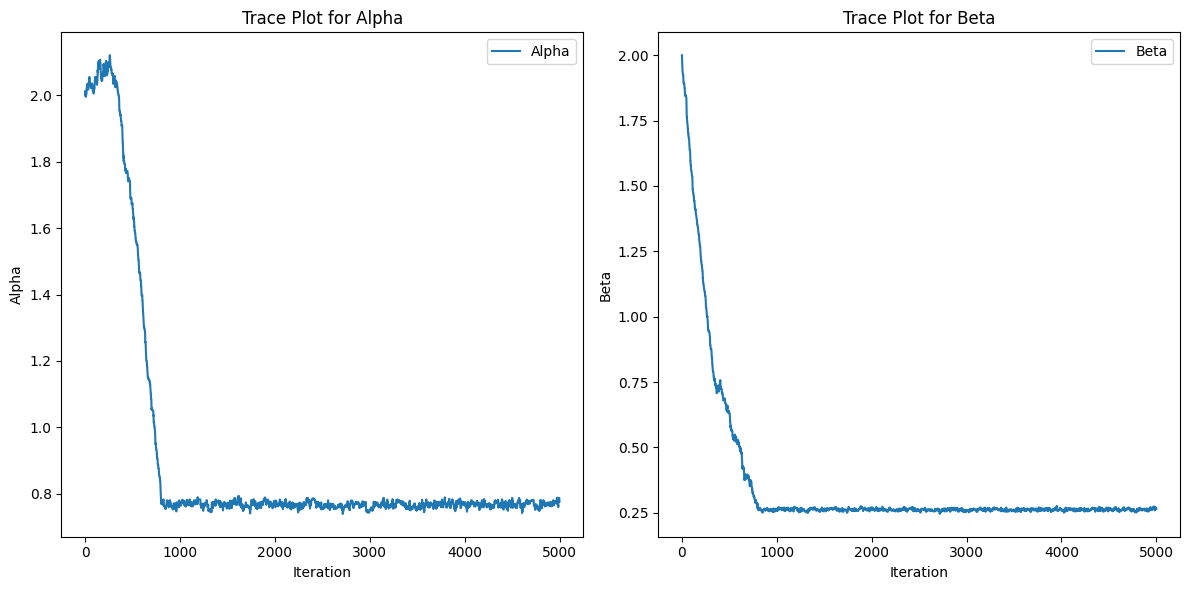

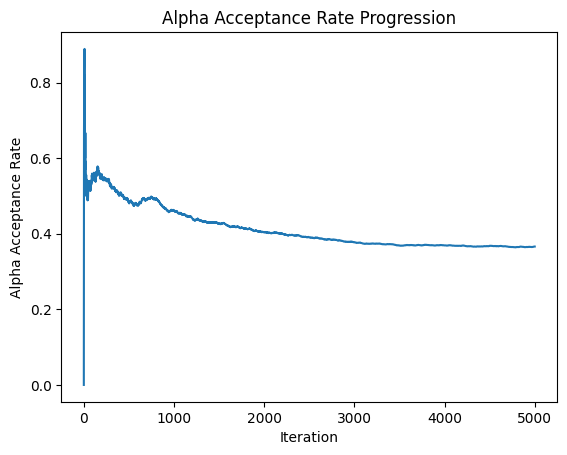

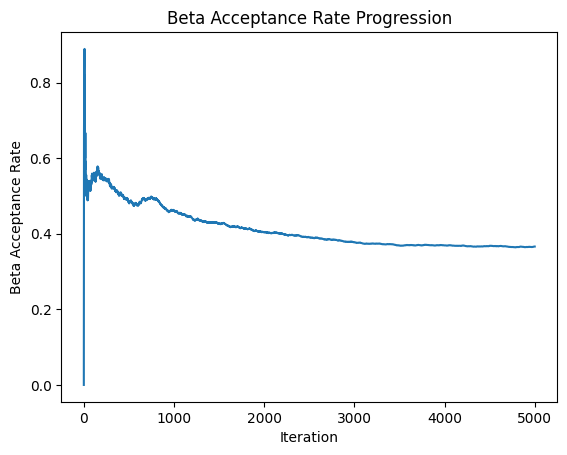

In [23]:
# Perform Gamma regression
print(f"[Info:] Performing Gamma Regression on 'NMHC(GT)'")
samples_gamma['NMHC(GT)'] = metropolis_gamma(y_gamma[:, 0], iterations=5000, step_alpha=0.008, step_beta=0.008)

[Info:] Performing Gamma Matropolis-Hastings Regression on 'NOx(GT)'
Iteration 100: Acceptance Rate = 0.97
Iteration 200: Acceptance Rate = 0.89
Iteration 300: Acceptance Rate = 0.82
Iteration 400: Acceptance Rate = 0.72
Iteration 500: Acceptance Rate = 0.66
Iteration 600: Acceptance Rate = 0.62
Iteration 700: Acceptance Rate = 0.61
Iteration 800: Acceptance Rate = 0.58
Iteration 900: Acceptance Rate = 0.55
Iteration 1000: Acceptance Rate = 0.53
Iteration 1100: Acceptance Rate = 0.52
Iteration 1200: Acceptance Rate = 0.50
Iteration 1300: Acceptance Rate = 0.49
Iteration 1400: Acceptance Rate = 0.47
Iteration 1500: Acceptance Rate = 0.46
Iteration 1600: Acceptance Rate = 0.45
Iteration 1700: Acceptance Rate = 0.44
Iteration 1800: Acceptance Rate = 0.42
Iteration 1900: Acceptance Rate = 0.42
Iteration 2000: Acceptance Rate = 0.41
Iteration 2100: Acceptance Rate = 0.40
Iteration 2200: Acceptance Rate = 0.39
Iteration 2300: Acceptance Rate = 0.39
Iteration 2400: Acceptance Rate = 0.39
Iter

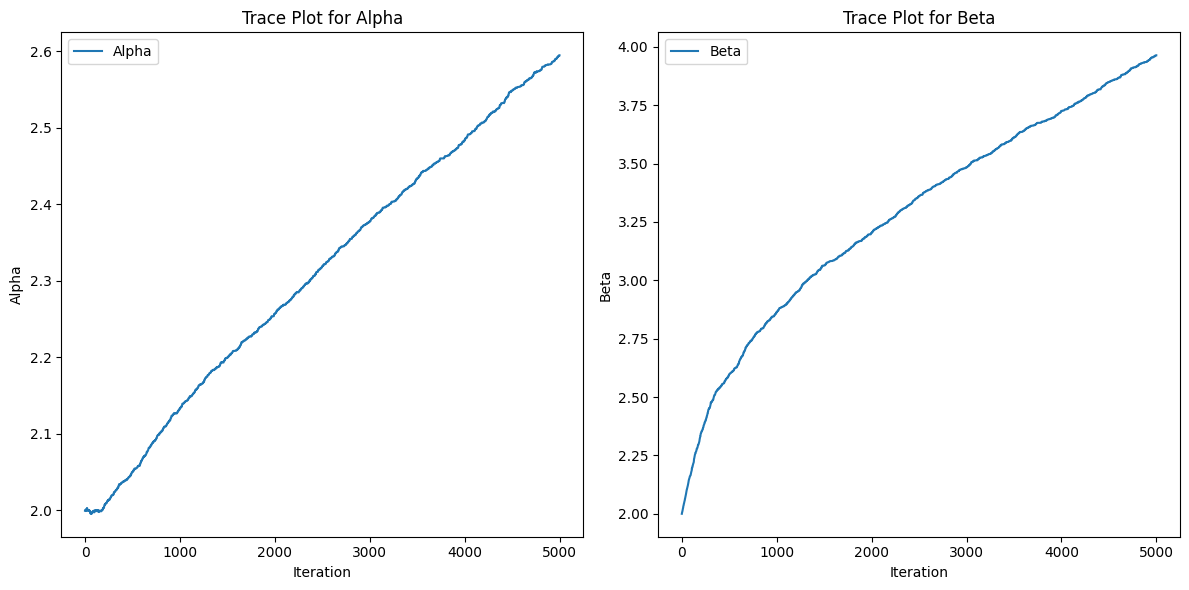

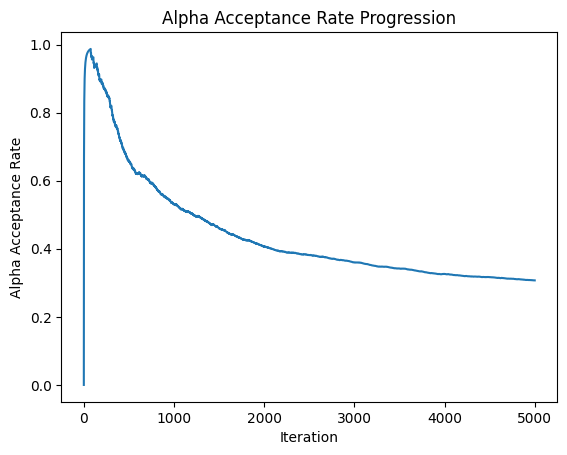

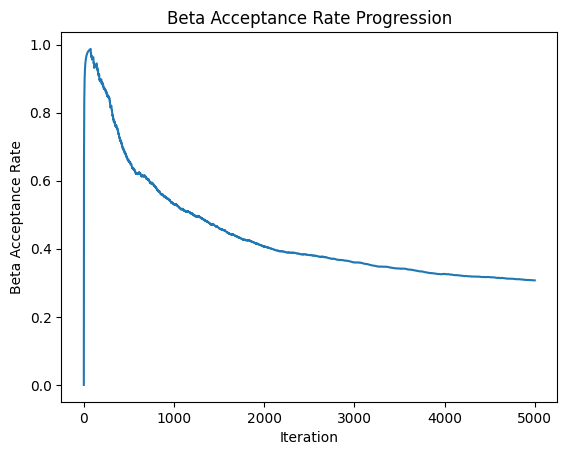

In [24]:
# Perform Gamma regression
print(f"[Info:] Performing Gamma Matropolis-Hastings Regression on 'NOx(GT)'")
# step_alpha=0.002, step_beta=0.000001
# iterations=5000, step_alpha=0.02, step_beta=0.0002
samples_gamma['NOx(GT)'] = metropolis_gamma(
    y_gamma[:, 1] / np.max(y_gamma[:, 1]),
    feature_name="NOx(GT)",
    iterations=5000,
    step_alpha=0.0005,
    step_beta=0.001
)

In [44]:
def exponential_posterior(beta, y):
    likelihood = np.sum(expon.logpdf(y, scale=1/beta))
    prior_beta = -0.5 * (beta - 2)**2  # Weak prior centered around 2
    #prior_beta = -0.5 * ((beta - 1)**2 / 0.5**2) # narrow prior
    return likelihood + prior_beta

def metropolis_exponential(y, iterations=5000, step_beta=0.01):
    beta = 2.0  # Initialize beta
    samples = []
    trace_beta = []
    acceptance_count = 0

    for t in range(iterations):
        beta_new = abs(beta + np.random.normal(0, step_beta))

        posterior_current = exponential_posterior(beta, y)
        posterior_new = exponential_posterior(beta_new, y)

        acceptance_ratio = np.exp(posterior_new - posterior_current)

        if np.random.rand() < acceptance_ratio:
            beta = beta_new
            acceptance_count += 1

        samples.append(beta)
        trace_beta.append(beta)

        # Print acceptance rate every 100 iterations
        if (t + 1) % 100 == 0:
            print(f"Iteration {t + 1}: Acceptance Rate = {acceptance_count / (t + 1):.2f}")

    # Plot the trace for beta
    plt.figure(figsize=(8, 4))
    plt.plot(trace_beta, label='Beta')
    plt.title('Trace Plot for Beta')
    plt.xlabel('Iteration')
    plt.ylabel('Beta')
    plt.legend()
    plt.show()

    # Plot the acceptance rate progression
    acceptance_rates = [np.sum(np.diff(trace_beta[:i]) != 0) / i for i in range(1, len(trace_beta))]
    plt.figure()
    plt.plot(acceptance_rates)
    plt.title("Beta Acceptance Rate Progression")
    plt.xlabel("Iteration")
    plt.ylabel("Beta Acceptance Rate")
    plt.show()

    return np.array(samples)

[Info:] Performing Gamma Metropolis Exponential Regression on 'NOx(GT)'
Iteration 100: Acceptance Rate = 0.56
Iteration 200: Acceptance Rate = 0.55
Iteration 300: Acceptance Rate = 0.52
Iteration 400: Acceptance Rate = 0.49
Iteration 500: Acceptance Rate = 0.51
Iteration 600: Acceptance Rate = 0.50
Iteration 700: Acceptance Rate = 0.50
Iteration 800: Acceptance Rate = 0.50
Iteration 900: Acceptance Rate = 0.51
Iteration 1000: Acceptance Rate = 0.50
Iteration 1100: Acceptance Rate = 0.51
Iteration 1200: Acceptance Rate = 0.51
Iteration 1300: Acceptance Rate = 0.50
Iteration 1400: Acceptance Rate = 0.50
Iteration 1500: Acceptance Rate = 0.51
Iteration 1600: Acceptance Rate = 0.51
Iteration 1700: Acceptance Rate = 0.51
Iteration 1800: Acceptance Rate = 0.51
Iteration 1900: Acceptance Rate = 0.51
Iteration 2000: Acceptance Rate = 0.50
Iteration 2100: Acceptance Rate = 0.51
Iteration 2200: Acceptance Rate = 0.51
Iteration 2300: Acceptance Rate = 0.51
Iteration 2400: Acceptance Rate = 0.51
I

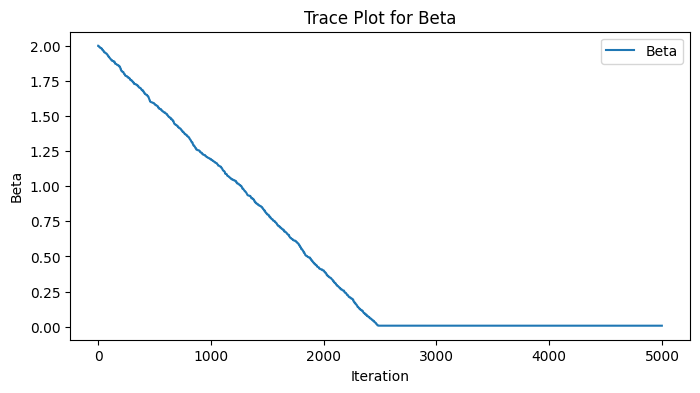

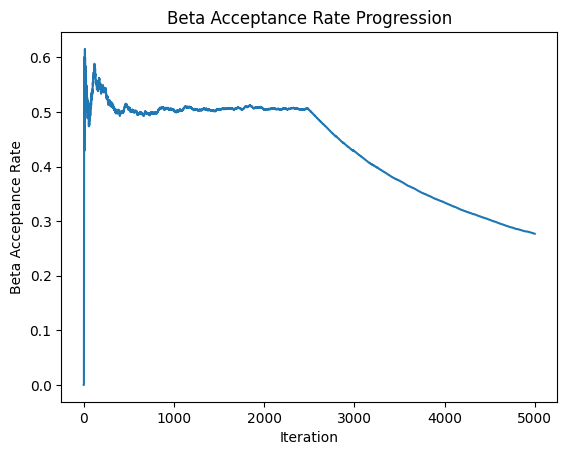

In [53]:
# Perform Exponential regression
print("[Info:] Performing Gamma Metropolis Exponential Regression on 'NOx(GT)'")
# iterations=5000, step_beta=0.002
samples_exponential = metropolis_exponential(y_gamma[:, 1], iterations=5000, step_beta=0.002)

In [31]:
# Linear Regression: Gibbs Sampling
def linear_posterior(beta, sigma2, X, y):
    residuals = y - X @ beta
    likelihood = -0.5 * len(y) * np.log(2 * np.pi * sigma2) - np.sum(residuals**2) / (2 * sigma2)
    prior_beta = -0.5 * np.sum(beta**2 / 10**2)  # Weak prior
    prior_sigma2 = -1.0 / sigma2  # Weak prior for sigma2
    return likelihood + prior_beta + prior_sigma2

def gibbs_linear(X, y, iterations=5000):
    N, p = X.shape
    beta = np.zeros(p)
    sigma2 = 1.0
    samples = []

    for _ in range(iterations):
        # Sample beta given sigma2
        Sigma_beta = np.linalg.inv(X.T @ X / sigma2 + np.eye(p) / 10**2)
        mu_beta = Sigma_beta @ (X.T @ y / sigma2)
        beta = np.random.multivariate_normal(mu_beta, Sigma_beta)

        # Sample sigma2 given beta
        residuals = y - X @ beta
        alpha_post = (N / 2) + 1
        beta_post = np.sum(residuals**2) / 2
        sigma2 = 1 / np.random.gamma(alpha_post, 1 / beta_post)

        samples.append((beta, sigma2))
    return samples

In [32]:
# Extract features for Linear regression
y_linear = data_transformed['CO(GT)'].values
X_linear = data_transformed[[
    'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)'
]].values

# Perform Linear regression
print("[Info:] Performing Linear Regression")
samples_linear = gibbs_linear(X_linear, y_linear)

[Info:] Performing Linear Regression


In [33]:
# Display results
print("Gamma Regression Samples:")
for feature, samples in samples_gamma.items():
    print(f"{feature}: Last 5 samples:")
    print(samples[-5:])

print("\nLinear Regression Samples:")
print("Last 5 samples of coefficients and sigma2:")
print(samples_linear[-5:])

Gamma Regression Samples:
NMHC(GT): Last 5 samples:
[[0.78733391 0.26705442]
 [0.78733391 0.26705442]
 [0.78733391 0.26705442]
 [0.77613756 0.2651255 ]
 [0.77613756 0.2651255 ]]
NOx(GT): Last 5 samples:
[[2.59402074 3.96255581]
 [2.59402074 3.96255581]
 [2.59448974 3.96345606]
 [2.59448974 3.96345606]
 [2.59448974 3.96345606]]

Linear Regression Samples:
Last 5 samples of coefficients and sigma2:
[(array([-0.1808653 ,  0.07479531,  0.71741165,  0.07011475,  0.03848729]), 0.5270765179821257), (array([-0.15520071,  0.09301874,  0.71343933,  0.06174481,  0.02198937]), 0.5304884236351295), (array([-0.13203946,  0.08984424,  0.7141518 ,  0.03277041,  0.01325997]), 0.5314847696585286), (array([-0.13008013,  0.08197826,  0.71855672,  0.03560676,  0.02704087]), 0.5422655466784599), (array([-0.12675214,  0.06369698,  0.7198316 ,  0.05039971, -0.00800302]), 0.5299801616962396)]


Gamma Regression Trace Plot for Alpha and Beta

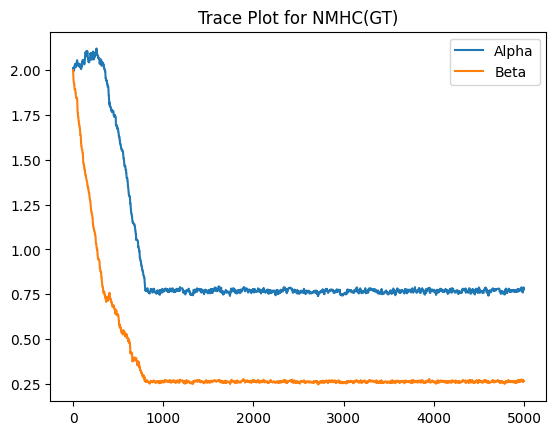

In [34]:
plt.plot([s[0] for s in samples_gamma['NMHC(GT)']], label='Alpha')
plt.plot([s[1] for s in samples_gamma['NMHC(GT)']], label='Beta')
plt.title("Trace Plot for NMHC(GT)")
plt.legend()
plt.savefig("Trace Plot for NMHC(GT).png")
plt.show()

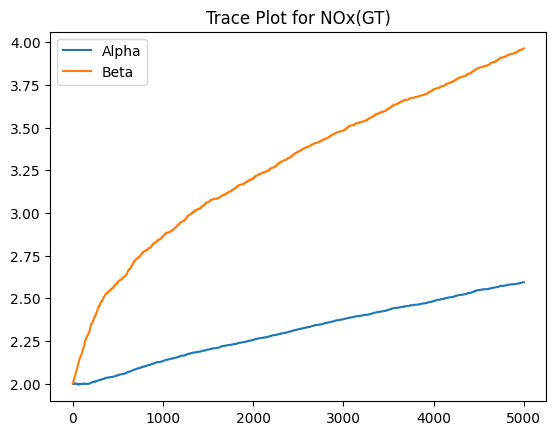

In [35]:
plt.plot([s[0] for s in samples_gamma['NOx(GT)']], label='Alpha')
plt.plot([s[1] for s in samples_gamma['NOx(GT)']], label='Beta')
plt.title("Trace Plot for NOx(GT)")
plt.legend()
plt.savefig("Trace Plot for NOx(GT).png")
plt.show()

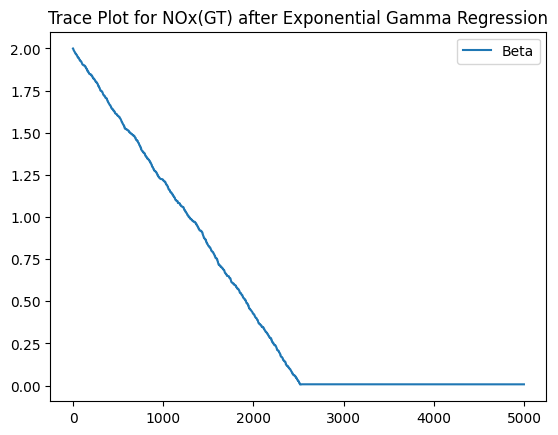

In [42]:
plt.plot(samples_exponential, label='Beta')
plt.title("Trace Plot for NOx(GT) after Exponential Gamma Regression")
plt.legend()
plt.savefig("Trace Plot for NOx(GT) after Exponential Gamma Regression.png")
plt.show()

Trace Plot for Beta and Sigma Coefficients for Linear Regression with Normal Distribution

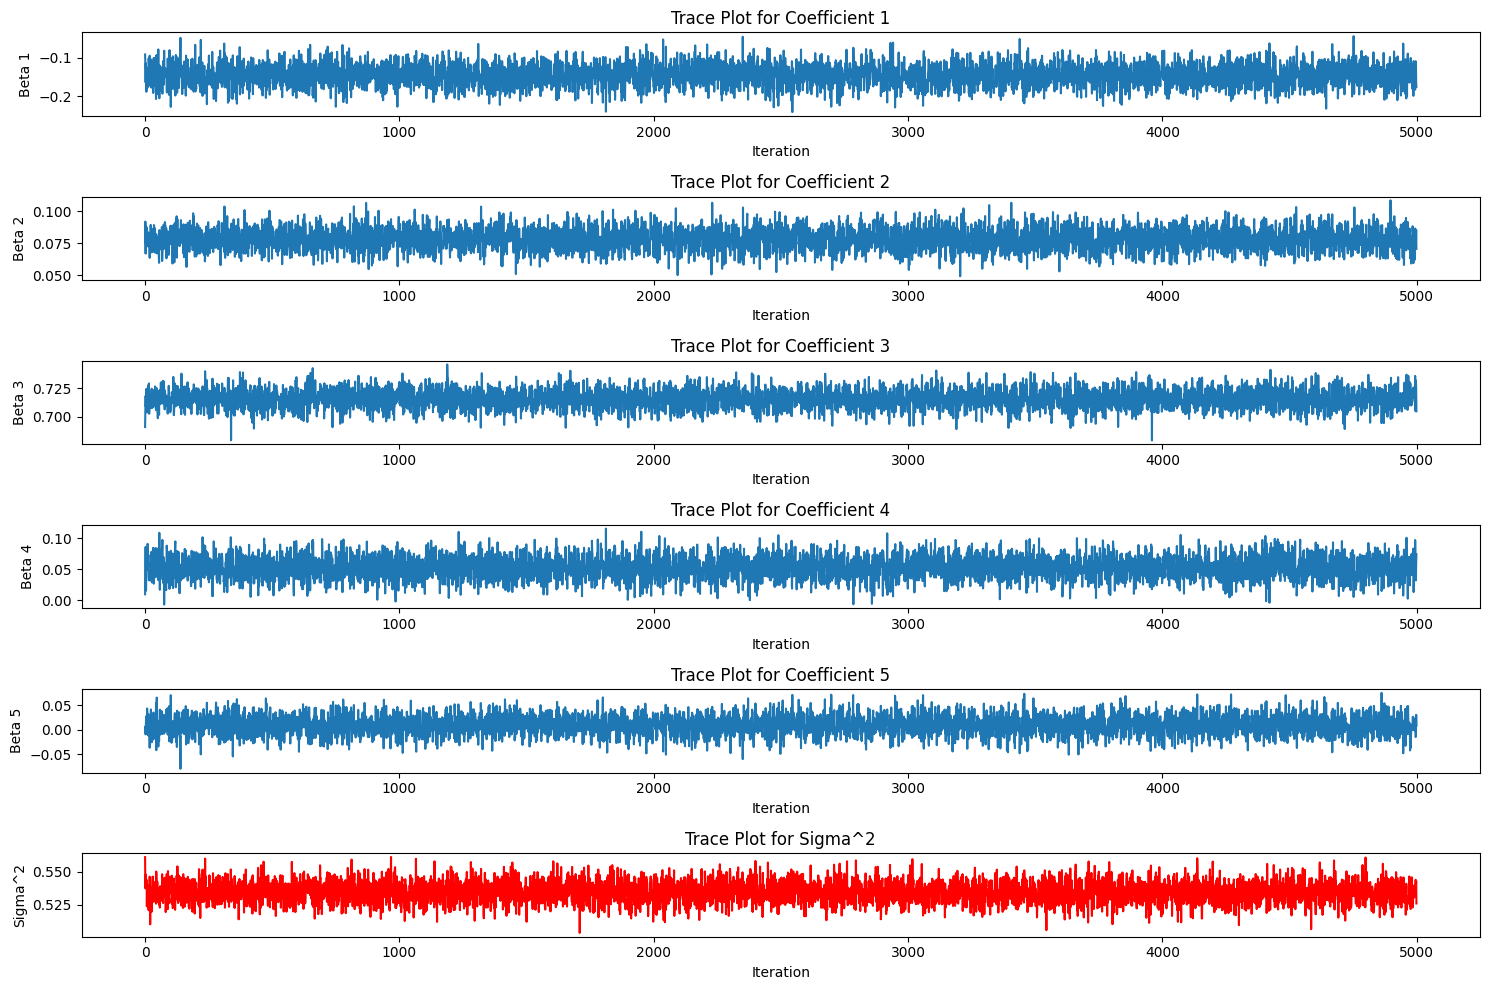

In [13]:
# Extract coefficients and sigma2 from the samples
coefficients = [s[0] for s in samples_linear]
sigma2_values = [s[1] for s in samples_linear]
num_coefficients = len(coefficients[0])

plt.figure(figsize=(15, 10))
for i in range(num_coefficients):
    plt.subplot(num_coefficients + 1, 1, i + 1)
    plt.plot([coef[i] for coef in coefficients])
    plt.title(f"Trace Plot for Coefficient {i+1}")
    plt.xlabel("Iteration")
    plt.ylabel(f"Beta {i+1}")

# Plot trace for sigma2
plt.subplot(num_coefficients + 1, 1, num_coefficients + 1)
plt.plot(sigma2_values, color='red')
plt.title("Trace Plot for Sigma^2")
plt.xlabel("Iteration")
plt.ylabel("Sigma^2")

plt.tight_layout()
plt.savefig("trace_normal_lin.png")
plt.show()

1.	Trace Plot for Coefficients (β1\beta_1β1 to β5\beta_5β5):
o	Stability:
	Each trace plot shows the coefficients fluctuating within a narrow band, suggesting stability.
o	Mixing:
	The chains do not exhibit clear patterns or drifts, which indicates that they are well-mixed and exploring the posterior effectively.
o	Possible Concern:
	If the fluctuations are too narrow, it might imply that the sampler is being too conservative in proposing new values. This could result in insufficient exploration of the posterior.
2.	Trace Plot for Residual Variance (σ2\sigma^2σ2):
o	Stability:
	The chain for σ2\sigma^2σ2 appears to be relatively stable, with values centered around a specific range.
o	Mixing:
	The fluctuations are reasonable, indicating that the chain is exploring the parameter space adequately.
o	Possible Concern:
	There is slightly more fluctuation compared to the coefficients. This is expected because σ2\sigma^2σ2 is sampled directly from a distribution with larger variance.
3.	No Evidence of Stuck Chains:
o	The chains for all parameters (both coefficients and σ2\sigma^2σ2) do not show flat regions or trends that would indicate "sticking" or poor convergence.

In [18]:
len(data_transformed["NOx(GT)"])

9357

Posterior Summary

In [55]:
alpha_nmch_mean = np.mean([s[0] for s in samples_gamma['NMHC(GT)']])
beta_nmch_mean = np.mean([s[1] for s in samples_gamma['NMHC(GT)']])
print(f"Posterior mean of Alpha for NMHC(GT): {alpha_nmch_mean}")
print(f"Posterior mean of Beta for NMHC(GT): {beta_nmch_mean}")

Posterior mean of Alpha for NMHC(GT): 0.9165570375372266
Posterior mean of Beta for NMHC(GT): 0.35975927567090377


In [56]:
alpha_nmch_mean = np.mean([s[0] for s in samples_gamma['NOx(GT)']])
beta_nmch_mean = np.mean([s[1] for s in samples_gamma['NOx(GT)']])
print(f"Posterior mean of Alpha for NOx(GT): {alpha_nmch_mean}")
print(f"Posterior mean of Beta for NOx(GT): {beta_nmch_mean}")

Posterior mean of Alpha for NOx(GT): 2.3088271469232216
Posterior mean of Beta for NOx(GT): 3.2809451996471246


In [59]:
beta_nmch_mean = np.mean(samples_exponential)
print(f"Posterior mean after Exponential Gamma Regression of Beta for NOx(GT): {beta_nmch_mean}")

Posterior mean after Exponential Gamma Regression of Beta for NOx(GT): 0.5007205225918471


Posterior Predictive Checks

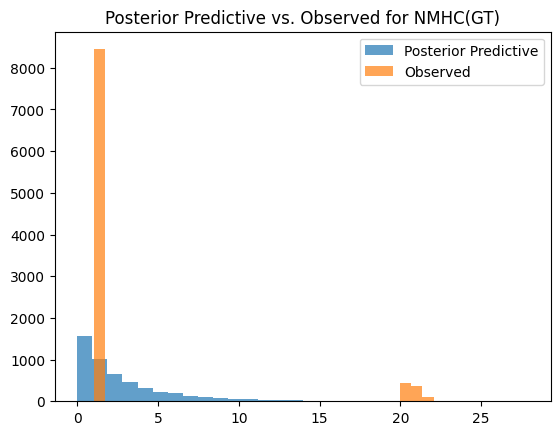

In [67]:
y_pred = [gamma.rvs(a=s[0], scale=1/s[1]) for s in samples_gamma['NMHC(GT)']]
plt.hist(y_pred, bins=30, alpha=0.7, label='Posterior Predictive')
plt.hist(y_gamma[:, 0], bins=30, alpha=0.7, label='Observed')
plt.legend()
plt.title("Posterior Predictive vs. Observed for NMHC(GT)")
plt.savefig("Posterior Predictive vs. Observed for NMHC(GT).png")
plt.show()

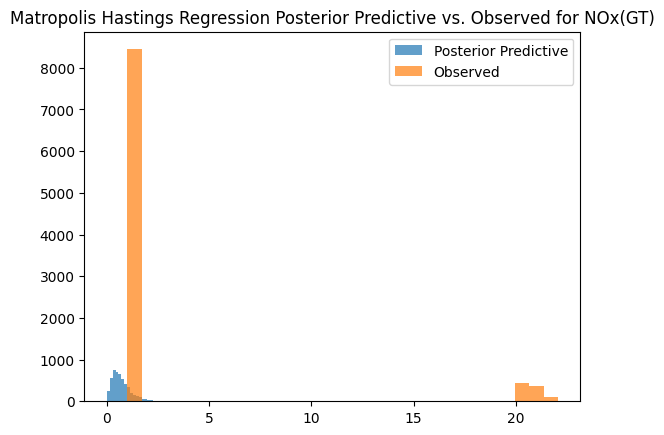

In [71]:
y_pred = [gamma.rvs(a=s[0], scale=1/s[1]) for s in samples_gamma['NOx(GT)']]
plt.hist(y_pred, bins=30, alpha=0.7, label='Posterior Predictive')
plt.hist(y_gamma[:, 0], bins=30, alpha=0.7, label='Observed')
plt.legend()
plt.title("Matropolis Hastings Regression Posterior Predictive vs. Observed for NOx(GT)")
plt.savefig("Matropolis Hastings Regression Posterior Predictive vs. Observed for NOx(GT).png")
plt.show()

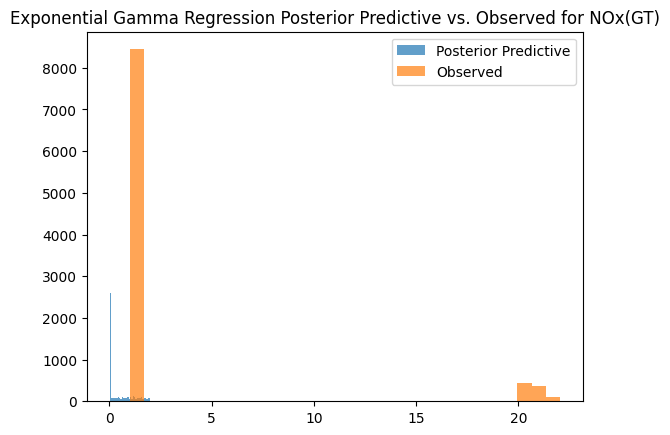

In [70]:
#y_pred = [gamma.rvs(a=s[0], scale=1/s[1]) for s in samples_exonential]
plt.hist(samples_exponential, bins=30, alpha=0.7, label='Posterior Predictive')
plt.hist(y_gamma[:, 0], bins=30, alpha=0.7, label='Observed')
plt.legend()
plt.title("Exponential Gamma Regression Posterior Predictive vs. Observed for NOx(GT)")
plt.savefig("Exponential Gamma Regression Posterior Predictive vs. Observed for NOx(GT).png")
plt.show()

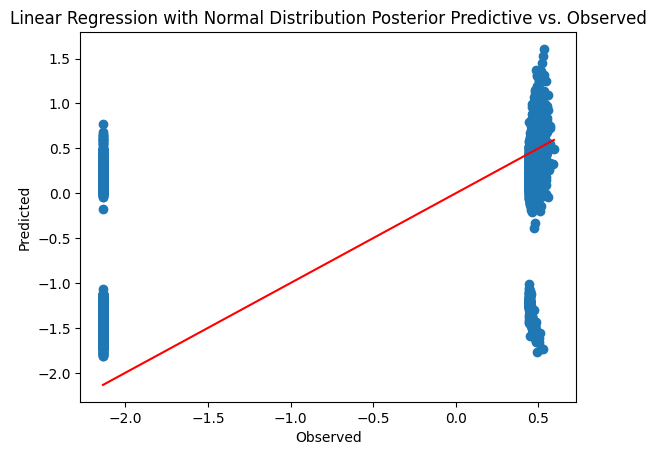

In [72]:
y_pred = [X_linear @ s[0] for s in samples_linear]
plt.scatter(y_linear, np.mean(y_pred, axis=0))
plt.plot([min(y_linear), max(y_linear)], [min(y_linear), max(y_linear)], color='red')
plt.title("Linear Regression with Normal Distribution Posterior Predictive vs. Observed")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.savefig("Linear Regression with Normal Distribution Posterior Predictive vs. Observed.png")
plt.show()